# NHS Prescription Costs Trend
This is an analysis of the prescription data totals for the UK as a whole. Showing the total costs of prescription drugs and the proportion of that cost that is down to generic drugs.
Data.gov open datasets [GP practice prescribing data - Presentation level](https://data.gov.uk/dataset/176ae264-2484-4afe-a297-d51798eb8228/gp-practice-prescribing-data-presentation-level)


## Package Imports

In [78]:
import numpy as np
import pandas as pd
import re
import os
import gc

## Find data files
Finds all of the Practice prescribing data csv files that match the patter of the Practice prescribing data. The data can be downloaded and extracted using the included bash script.
```shell
#!/bin/bash
downloads=`cat datasets.txt`
mkdir -p ./zips
mkdir -p ./extracted
for url in $downloads;
do
    filename=`basename ${url}`
    echo $url
    echo $filename
    dir_name=`basename $filename .zip`
    full_dir=./extracted/$dir_name
    mkdir -p $full_dir
    curl $url > ./zips/$filename
    unzip ./zips/$filename -d $full_dir
done
```

datasets.txt is a list of links to the monthly data zip files.
```
https://files.digital.nhs.uk/94/405A94/2018_12_Dec.zip
https://files.digital.nhs.uk/96/A7878A/2018_11_Nov.zip
https://files.digital.nhs.uk/33/3EE982/2018_10_Oct.zip
https://files.digital.nhs.uk/5C/FE61C4/2018_09_Sep.zip
https://files.digital.nhs.uk/43/C6644B/2018_08_Aug.zip
https://files.digital.nhs.uk/7E/FC3950/2018_07_Jul.zip
```

In [79]:
datafile_match = re.compile(r"\w\d{6}PDPI\sBNFT\.CSV")
datafiles = []
for root, dirs, files in os.walk("extracted"):
    for f in files:
        if datafile_match.match(f.upper()):
            datafiles.append(os.path.join(root,f))


## Process data files and create summary
This is the processing section that reads all of the large CSV files in one at a time. Each one is ~10 million rows, so each one takes a while to process. Once they've been summarised the data frames are deleted to make way for the next one.

The processing that occurs for each one is:
* The column headers are cleaned up with leading and trailing spaces removed.
* The first item in the period column is used to represent the time period of the entire file.
* The sum of the  **actual cost** column (ACT COST) is calculated.
* BNF Codes that matched the Generic code of 9 characters then AA, then the rest of the BNF code are filtered into a new data frame that now lists just the Generic drug entries.
* The sum of the **actual cost** column (ACT COST) is calculated of the generic drugs.

The summary is then stored in a new data set.

In [80]:
monthly_totals = {"PERIOD":[],"TOTAL":[],"GENERIC":[]}
for datafile in datafiles:
    df = pd.read_csv(datafile, sep=",")
    df.columns = [col.strip() for col in df.columns]
    if 'PERIOD' in df and 'ACT COST' in df and 'BNF CODE' in df:
        period = str(df['PERIOD'].iloc[0])
        total = df['ACT COST'].sum()
        df_generics = df[df['BNF CODE'].str.match(r"^\S{9}AA")]
        generics = df_generics['ACT COST'].sum()
        monthly_totals["PERIOD"].append(period)
        monthly_totals["TOTAL"].append(total)
        monthly_totals["GENERIC"].append(generics)
    del df
    gc.collect()

## Data formatting and getting to the correct type
The Summary data frame is now formatted with Period as a Date field and the total and generic fields scaled down to represent millions of pounds.

In [81]:
time_trends=pd.DataFrame(data=monthly_totals)
time_trends['PERIOD'] = pd.to_datetime(time_trends['PERIOD'], format='%Y%m')
time_trends['TOTAL'] = time_trends['TOTAL']/1000000
time_trends['GENERIC'] = time_trends['GENERIC']/1000000
time_trends

,PERIOD,TOTAL,GENERIC
0,2017-01-01,673.701184,380.864733
1,2017-02-01,629.058403,354.189755
2,2017-04-01,631.344204,352.338049
3,2017-05-01,700.264801,391.281398
4,2017-06-01,727.831844,413.664641
5,2017-07-01,707.524407,403.305150
6,2017-08-01,689.886489,387.583875
7,2017-09-01,702.632823,397.659786
8,2017-10-01,731.830218,416.085633
9,2017-11-01,708.005873,394.951544


Text(0, 0.5, '£ in Millions')

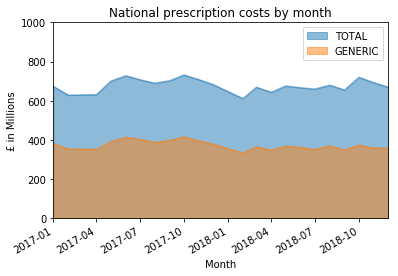

In [82]:
ax = time_trends.plot.area(x='PERIOD', ylim=(0,1000), stacked=False, title="National prescription costs by month")
ax.set_xlabel("Month")
ax.set_ylabel("£ in Millions")